Comparing methods for dynamic functional connectivity in brain imaging
--
This notebook implements the first few analysis steps required for dynamic connectivity analysis based on sliding-windows

Step 1 -- Open time series

Scan the directory and read time series 

In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
from nilearn.plotting import plot_matrix, plot_connectome

%matplotlib inline

In [2]:
import os 
datapath = '/Users/nicolasfarrugia/Documents/recherche/data_mpilmbb/'
fileslist = os.listdir(os.path.join(datapath,'10subjects')) 

Print the list of files 

In [3]:
fileslist

['subj_010001_ses-02_task-rest_acq-AP_run-01_M_BASC_scale064.npz',
 'subj_010001_ses-02_task-rest_acq-AP_run-02_M_BASC_scale064.npz',
 'subj_010001_ses-02_task-rest_acq-PA_run-01_M_BASC_scale064.npz',
 'subj_010001_ses-02_task-rest_acq-PA_run-02_M_BASC_scale064.npz',
 'subj_010002_ses-02_task-rest_acq-AP_run-01_M_BASC_scale064.npz',
 'subj_010002_ses-02_task-rest_acq-AP_run-02_M_BASC_scale064.npz',
 'subj_010002_ses-02_task-rest_acq-PA_run-01_M_BASC_scale064.npz',
 'subj_010002_ses-02_task-rest_acq-PA_run-02_M_BASC_scale064.npz',
 'subj_010004_ses-02_task-rest_acq-AP_run-01_M_BASC_scale064.npz',
 'subj_010004_ses-02_task-rest_acq-AP_run-02_M_BASC_scale064.npz',
 'subj_010004_ses-02_task-rest_acq-PA_run-01_M_BASC_scale064.npz',
 'subj_010004_ses-02_task-rest_acq-PA_run-02_M_BASC_scale064.npz',
 'subj_010005_ses-02_task-rest_acq-AP_run-01_M_BASC_scale064.npz',
 'subj_010005_ses-02_task-rest_acq-AP_run-02_M_BASC_scale064.npz',
 'subj_010005_ses-02_task-rest_acq-PA_run-01_M_BASC_scale064.n

Open each file (each file has a time series and an id) and store them in lists 

In [4]:
allts = []
allid = []

for curfile in fileslist:
    allts.append(np.load(os.path.join(datapath,'10subjects',curfile))['ts'])
    allid.append(np.load(os.path.join(datapath,'10subjects',curfile))['id'])

Turn the list into a numpy array, and print the shape of the resulting array 

In [5]:
allts = np.stack(allts)
print(allts.shape)

(40, 652, 93)


40 files, 652 volumes, 93 ROIs

Let's print some time series, just for fun 

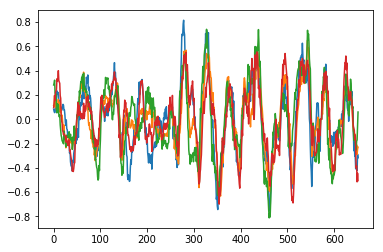

In [15]:
subject = 12
plt.plot(allts[subject,:,3:7]) ## rois 3 to 7 

Step 2 - Sliding windows

The function dfc_slid_window implements the following :
- cutting the data in sliding windows of length ws, sliding by steps of ss
- Applies a Tucker window for tapering (to smooth edge effects) 

It expect an input in the form [subjects,volumes,regions], so if you want to calculate sliding windows on a single subjects, reshape it to [1,volumes,regions] using np.reshape

Let's check its syntax

In [16]:
from dfc import dfc_slid_window
dfc_slid_window?

Calculate sliding windows 

In [17]:
all_sl,_ = dfc_slid_window(allts,100)

In [19]:
print(all_sl.shape)

(40, 552, 100, 93)


this corresponds to (subjects, time , window size, regions )

Computing FC matrices for all windows

In [ ]:
from nilearn.connectome import ConnectivityMeasure
estimator = ConnectivityMeasure(kind='covariance',vectorize=False,discard_diagonal=True)

all_FC_sl = []

for sl in all_sl:
    all_FC_sl.append(estimator.fit_transform(sl))
    
    
all_FC_sl = np.stack(all_FC_sl)

In [ ]:
all_FC_sl.shape

In [ ]:
plot_matrix(all_FC_sl[0,13])

Calculate similarity across the temporal dimension 

recomputing connectivity and vectorizing to make it easier for calculating distance 

In [ ]:
from nilearn.connectome import ConnectivityMeasure
estimator = ConnectivityMeasure(kind='covariance',vectorize=True,discard_diagonal=True)

all_FC_sl = []

for sl in all_sl:
    all_FC_sl.append(estimator.fit_transform(sl))
    
    
all_FC_sl = np.stack(all_FC_sl)

go through all subjects

In [ ]:
all_FC_sl.shape

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

all_cosine_sim = []
for i,slFC in enumerate(all_FC_sl): # subjects
    #windows
    cur_sim = cosine_similarity(slFC)
    all_cosine_sim.append(cur_sim)
    plt.imshow(cur_sim,cmap=plt.cm.hot)
    plt.title(allid[i])
    plt.colorbar()
    plt.show()
    
all_cosine_sim = np.stack(all_cosine_sim)

Save the results 

In [ ]:
#np.savez_compressed(os.path.join(datapath,'FC_variability.npz'),all_cosine_sim=all_cosine_sim,ids=allid)

Redo it using precision

In [ ]:
from nilearn.connectome import ConnectivityMeasure
estimator = ConnectivityMeasure(kind='precision',vectorize=True,discard_diagonal=True)

all_FC_sl = []

for sl in all_sl:
    all_FC_sl.append(estimator.fit_transform(sl))
    
all_FC_sl = np.stack(all_FC_sl)

In [ ]:
all_cosine_sim = []
for i,slFC in enumerate(all_FC_sl): # subjects
    #windows
    cur_sim = cosine_similarity(slFC)
    all_cosine_sim.append(cur_sim)
    plt.imshow(cur_sim,cmap=plt.cm.hot)
    plt.title(allid[i])
    plt.colorbar()
    plt.show()
    
all_cosine_sim = np.stack(all_cosine_sim)

In [ ]:
np.savez_compressed(os.path.join(datapath,'FC_variability_precision.npz'),all_cosine_sim=all_cosine_sim,ids=allid)

In [ ]:
from nilearn.connectome import ConnectivityMeasure
estimator = ConnectivityMeasure(kind='tangent',vectorize=True,discard_diagonal=True)

all_FC_sl = []

for sl in all_sl:
    all_FC_sl.append(estimator.fit_transform(sl))
    
all_FC_sl = np.stack(all_FC_sl)

In [ ]:
all_cosine_sim = []
for i,slFC in enumerate(all_FC_sl): # subjects
    #windows
    cur_sim = cosine_similarity(slFC)
    all_cosine_sim.append(cur_sim)
    plt.imshow(cur_sim,cmap=plt.cm.hot)
    plt.title(allid[i])
    plt.colorbar()
    plt.show()
    
all_cosine_sim = np.stack(all_cosine_sim)

In [ ]:
np.savez_compressed(os.path.join(datapath,'FC_variability_tangent.npz'),all_cosine_sim=all_cosine_sim,ids=allid)